## Implementação de carro elétrico acionado por Motor CC com controle da velocidade pela tensão de armadura

### Importação das bibliotecas

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### EDOs das dinâmicas

In [34]:
# Dinâmica do motor e da translação

def func(x, t, L, Ea, Kv, Ra, J, b, r, c, m, g, alpha): 
    dx0dt = (Ea - Kv * x[1] - Ra * x[0]) / L # x[0] = ia, x[1] = w
    dx1dt = (Kv*x[0] - b*x[1] - c*x[1]**2*r - m*g*r*np.sin(alpha)) / J
    return (dx0dt, dx1dt)

### Parametrização

In [35]:
L = 0.02 # indutância
Kv = 1.39 # constante de velocidade
Ra = 0.1 # resistência de armadura

J = 0.05 # inércia
b = 0.1 # coeficiente de atrito viscoso

r = 20e-2 # raio da roda
c = 0.3 # coeficiente de atrito viscoso
m = 400 # massa
g = 9.8 # aceleração da gravidade

### Simulação da dinâmica

In [36]:
x0 = [0, 0]
Ea = 100
alpha = 0
t = np.linspace(0, 1, 100) # vetor de tempo
result = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha))

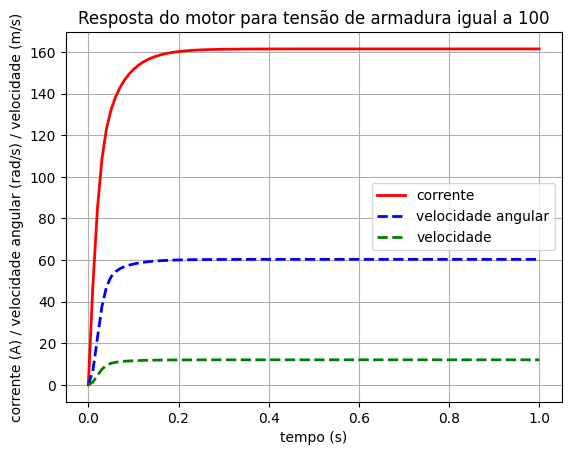

In [37]:
plt.figure()
plt.plot(t, result[:,0] , 'r-', linewidth=2, label='corrente')
plt.plot(t, result[:,1], 'b--', linewidth=2, label='velocidade angular')
plt.plot(t, result[:,1]*r, 'g--', linewidth=2, label='velocidade')
plt.xlabel('tempo (s)')
plt.ylabel('corrente (A) / velocidade angular (rad/s) / velocidade (m/s)')
plt.title(f'Resposta do motor para tensão de armadura igual a {Ea}')
plt.legend()
plt.grid()
plt.show()

### Implementando a malha de controle

In [49]:
# Implementação do controlador proporcional
# O objetivo é controlar a velocidade do carro (velocidade angular do motor vezes o raio da roda)

# Parâmetros do controlador
Kp = 0.5
Ki = 0.5
Kd = 0

V_ref = 10 # velocidade de referência
x0 = [0, 0]
Ea = 0
alpha = 0
cn = 50.4 # capacidade nominal da bateria
soc_total = 80 # soc total da bateria
t = np.linspace(0, 1, 100)
din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha))
ia = din[-1][0]
soc = soc_total - ia/2.8
w = din[-1][1]
v = w*r
erro = V_ref - v
v_history = [v]
Ea_history = [Ea]
Ref_history = [V_ref]
error_history = [erro]
ia_history = [ia]
soc_history = [soc]

$\frac{di_a}{dt} = E_a$

In [50]:
for i in range(200):
    if i == 100: # mudança na referência
        V_ref = 5
    Ea = Kp*erro + Ki*sum(error_history) + Kd*(erro - error_history[-1])
    if Ea > 100: # controle de saturação
        Ea = 100
    din = odeint(func, x0, t, args=(L, Ea, Kv, Ra, J, b, r, c, m, g, alpha))
    ia = din[-1][0]
    soc = soc_total - ia/cn
    w = din[-1][1]
    v = w*r
    erro = (V_ref - v)
    v_history.append(v)
    Ea_history.append(Ea)
    Ref_history.append(V_ref)
    error_history.append(erro)
    ia_history.append(ia)
    soc_history.append(soc)

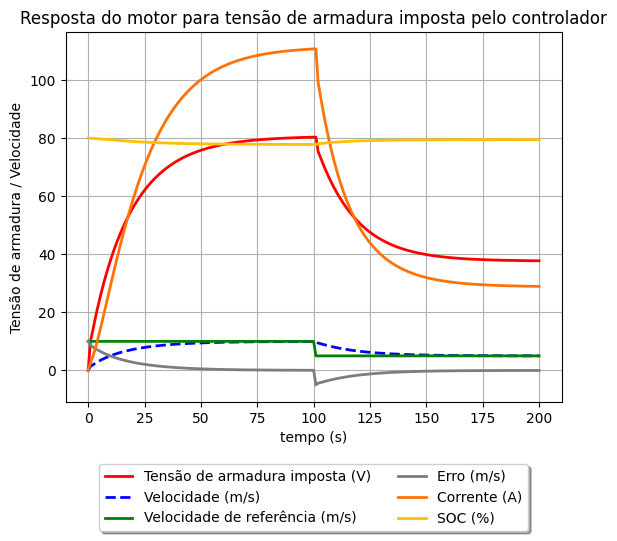

In [52]:
plt.figure()
plt.plot(Ea_history, 'r-', linewidth=2, label='Tensão de armadura imposta (V)')
plt.plot(v_history, 'b--', linewidth=2, label='Velocidade (m/s)')
plt.plot(Ref_history, 'g-', linewidth=2, label='Velocidade de referência (m/s)')
plt.plot(error_history, '#7D7D7D', linewidth=2, label='Erro (m/s)')
plt.plot(ia_history, '#FF720A', linewidth=2, label='Corrente (A)')
plt.plot(soc_history, '#FFC000', linewidth=2, label='SOC (%)')
plt.xlabel('tempo (s)')
plt.ylabel('Tensão de armadura / Velocidade')
plt.title('Resposta do motor para tensão de armadura imposta pelo controlador')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.grid()
plt.show()

### Aplicando controle de corrente a partir do estado de carga da bateria